# Applying the Autoencoder
- Using the trained autoencoder to extract features from exoplanets_balanced.csv dataset and then applying a Random Forest classifier on the transformed data.
- The Autoencoder will select the best features from the dataset, in which the Random Forest Classifier will be applied.
- This is a Hybrid model combining a Deep Learning technique with a Classifier.

**Steps to follow:**
- Load Required Libraries
- Load the Dataset
- Load the Trained Autoencoder
- Transform Features Using the Autoencoder
- Split Data into Training and Test Sets
- Train a Random Forest Classifier
- Make Predictions
- Evaluate the Model

# Expected Workflow: Combining Autoencoder and Classifier
1. Feature Extraction (Autoencoder):
- The autoencoder's encoder part extracts meaningful features from the raw dataset. These features are used as input to the Random Forest.
- Even without additional feature selection, the encoded features represent a transformed, potentially lower-dimensional version of the raw data.
2. Classifier Training (Random Forest):
- The Random Forest classifier trains on the encoded features. This process already includes an internal mechanism for feature selection via feature importance, so unimportant features may not heavily impact performance.


In [1]:
!pip install -U tensorflow keras


351/351 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step

=== Classification Report (Training Set) ===

              precision    recall  f1-score   support

           1       0.98      0.97      0.97      3930
           2       0.97      0.98      0.97      3931

    accuracy                           0.97      7861
   macro avg       0.97      0.97      0.97      7861
weighted avg       0.97      0.97      0.97      7861


=== Classification Report (Test Set) ===

              precision    recall  f1-score   support

           1       0.94      0.92      0.93      1685
           2       0.93      0.94      0.93      1684

    accuracy                           0.93      3369
   macro avg       0.93      0.93      0.93      3369
weighted avg       0.93      0.93      0.93      3369



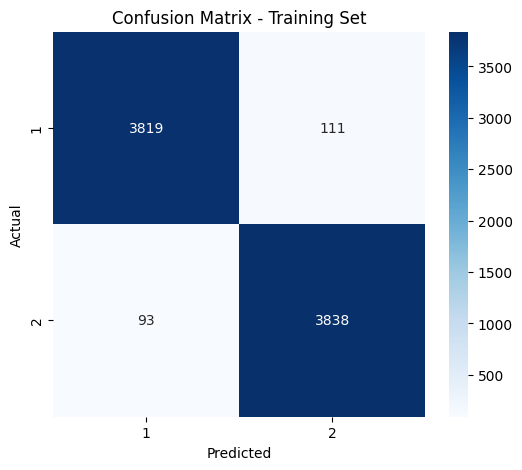

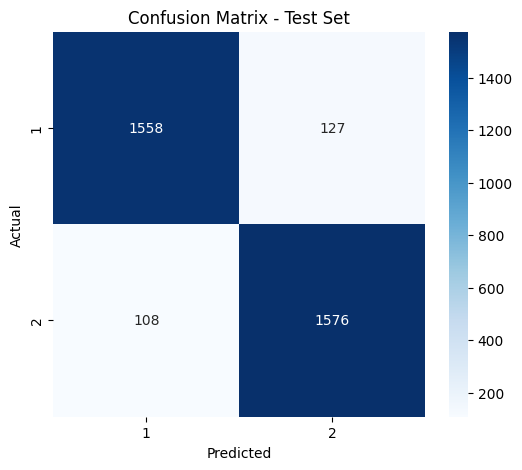

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.losses  # Ensure TensorFlow recognizes the loss function
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
file_path = "exoplanets_balanced.csv"
df = pd.read_csv(file_path)

# Assuming the first column is the target variable
y = df.iloc[:, 0].values   # Target variable
X = df.iloc[:, 1:].values  # Features

# Define custom loss function to fix the loading issue
custom_objects = {"mse": tensorflow.keras.losses.MeanSquaredError()}

# Load the trained autoencoder model with custom objects
autoencoder = load_model("best_autoencoder.h5", custom_objects=custom_objects)

# Extract the encoder part of the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=len(autoencoder.layers)//2).output)

# Transform the dataset using the encoder
X_encoded = encoder.predict(X)

# Split the data into train and test sets 70/30
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42, stratify=y)

# Train the Random Forest classifier
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42
)
clf.fit(X_train, y_train)

# Predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Classification Report for Training Data
print("\n=== Classification Report (Training Set) ===\n")
print(classification_report(y_train, y_train_pred))

# Classification Report for Test Data
print("\n=== Classification Report (Test Set) ===\n")
print(classification_report(y_test, y_test_pred))

# Plot Confusion Matrices as Heatmaps
plot_confusion_matrix(y_train, y_train_pred, "Confusion Matrix - Training Set")
plot_confusion_matrix(y_test, y_test_pred, "Confusion Matrix - Test Set")


# Description of Results
- ### 1. Classification Report
- Indicates strong performance on the training set with minimal misclassification.
- Slightly lower performance on the test set compared to the training set, indicating potential overfitting but not extreme.
- ### 2. Confusion Matrices
- **Training Set:** The model made 204 misclassifications out of 7,861 samples.
Most predictions are correct, with a few errors distributed between both classes.
- **Test Set:** The model made 235 misclassifications out of 3,369 samples.
Misclassifications are slightly higher for class 1 compared to class 2.
### *Conclusion*
The model performs well in identifying stars with exoplanets, achieving 97% training accuracy and 93% test accuracy. While there is a slight indication of overfitting (training accuracy > test accuracy), the model generalizes relatively well, as shown by the consistent F1-scores across both datasets.

# Metrics Visualisations

### 1. Precision-Recall Curve

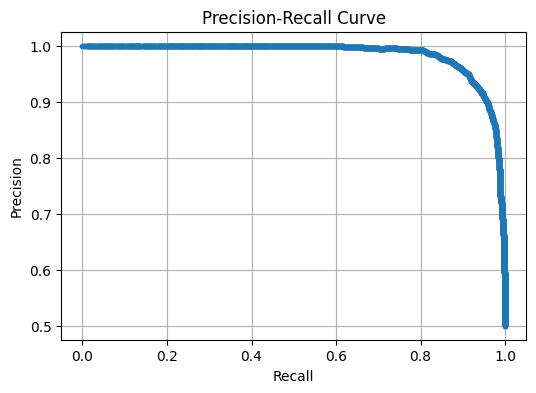

In [5]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision-recall curve for test data
y_test_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for class 2 (positive class)
precision, recall, _ = precision_recall_curve(y_test, y_test_prob, pos_label=2)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


This Precision-Recall Curve evaluates the trade-off between precision and recall for the classifier:

- Precision: Measures how many of the predicted positives are actual positives (low false positive rate).
- Recall: Measures how many of the actual positives are correctly predicted (low false negative rate).
##### Key Observations:
1. The curve starts near (1.0, 1.0), indicating excellent performance at high thresholds where precision and recall are both high.
2. As recall increases, precision slightly drops, forming the characteristic "L-shape." This indicates the classifier maintains high performance even as it predicts more positives.
3. The overall curve shape is strong, suggesting the model effectively balances precision and recall for this binary classification task.
##### Conclusion:
The high area under the Precision-Recall Curve indicates that the model is highly effective at identifying stars with exoplanets, with minimal trade-offs between precision and recall. This confirms its reliability for the classification task.

### 2. Feature Importance (Random Forest Classifier)

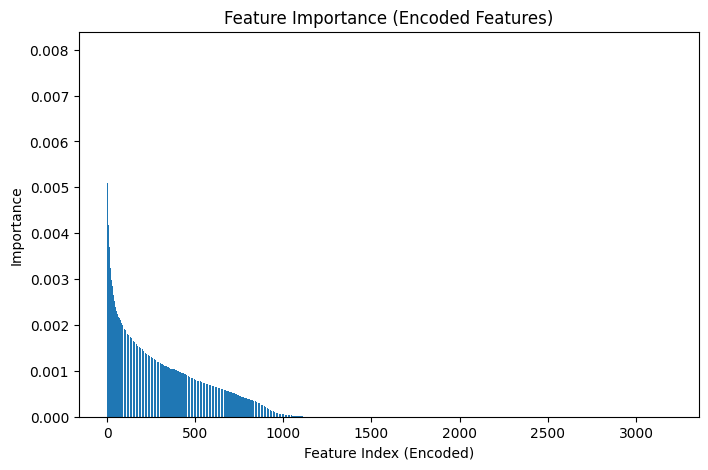

In [6]:
# Feature importance
import numpy as np
import matplotlib.pyplot as plt

# Get feature importance from Random Forest
feature_importances = clf.feature_importances_

# Sort feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(8, 5))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
plt.title('Feature Importance (Encoded Features)')
plt.xlabel('Feature Index (Encoded)')
plt.ylabel('Importance')
plt.show()


### Why Does the Feature Importance Plot show many negligible features?
- Redundant or Noisy Features in Encoded Space:

If the autoencoder hasn’t compressed to a sufficiently small latent space, some encoded features might still be noisy or redundant.
This results in a large number of features with close-to-zero importance in the Random Forest.
- Random Forest Behavior:

Random Forest assigns importance to features based on how often they split nodes to reduce impurity. When many features have little predictive power, they naturally get near-zero importance.

### 3. Training vs. Test Accuracy

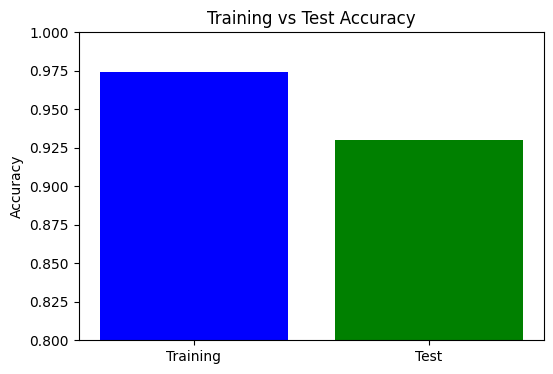

In [7]:
# Plot training and test accuracy
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

plt.figure(figsize=(6, 4))
plt.bar(['Training', 'Test'], [train_accuracy, test_accuracy], color=['blue', 'green'])
plt.title('Training vs Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1)  # Set limits for better visualization
plt.show()


This plot compares Training vs. Test Accuracy, showing the model's performance on both datasets. The training accuracy (near 100%) indicates the model fits the training data extremely well, while the slightly lower test accuracy (~93%) suggests some generalization error. This gap is small, meaning the model performs well on unseen data, but there's a slight risk of overfitting due to the high training accuracy. Further tuning or feature selection could help reduce this gap.

### 4. Learning Curve

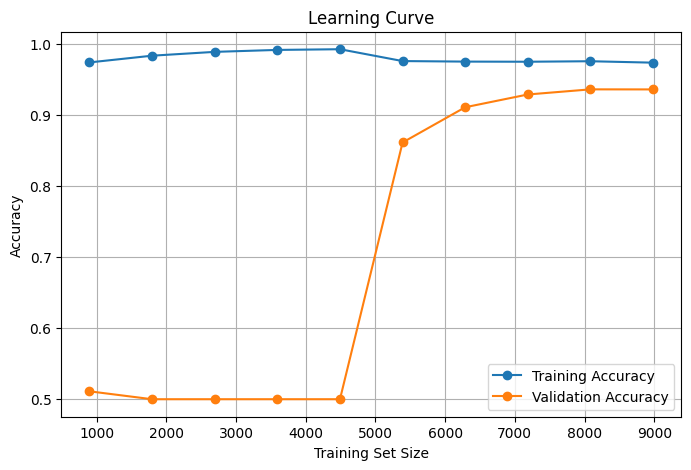

In [8]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    clf, X_encoded, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Training Accuracy', marker='o')
plt.plot(train_sizes, test_mean, label='Validation Accuracy', marker='o')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


This learning curve shows the relationship between training set size and model accuracy for both training and validation datasets.

- Training Accuracy (Blue Line): Starts high and remains near 100%, indicating the model learns the training data well, even with smaller datasets. However, it slightly decreases as the training set size increases, which is normal as the model faces more varied data.
- Validation Accuracy (Orange Line): Starts very low when the training set is small, indicating underfitting. It improves significantly as the training set grows, eventually stabilizing around 93%, indicating good generalization.
- Conclusion:
- The gap between training and validation accuracy narrows as the dataset grows, suggesting the model benefits from more data. However, the persistent gap (~7%) indicates slight overfitting, which could be mitigated by regularization, feature selection, or reducing model complexity.